In [ ]:
###########################################################
# The input shape of traj and head list as follows:
# traj: [batch_size, 2, traj_length]   2: latitude and longitude
# head: [batch_size, 8]   8: departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed, start_id, end_id
###########################################################


#

<class 'numpy.ndarray'>
(10000, 8)
[ 1.26000000e+02  6.16877091e-02 -7.73996295e-01 -7.02134033e-01
  4.82019478e-01  5.94862720e-01  7.20000000e+01  7.80000000e+01]
                  0             1             2             3             4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     173.537100     -0.019274     -0.055412     -0.020011     -0.011571   
std       60.260391      0.996798      0.936588      0.964146      1.002931   
min        0.000000     -1.103657     -1.129803     -1.047126     -1.145616   
25%      129.000000     -0.590254     -0.716672     -0.713789     -0.582796   
50%      177.000000     -0.321731     -0.312765     -0.291873     -0.341801   
75%      220.000000      0.196213      0.338229      0.379464      0.184171   
max      286.000000     23.984711     12.604339      7.820110     14.910312   

                  5             6             7  
count  10000.000000  10000.000000  10000.000000  
mean       0.006253   

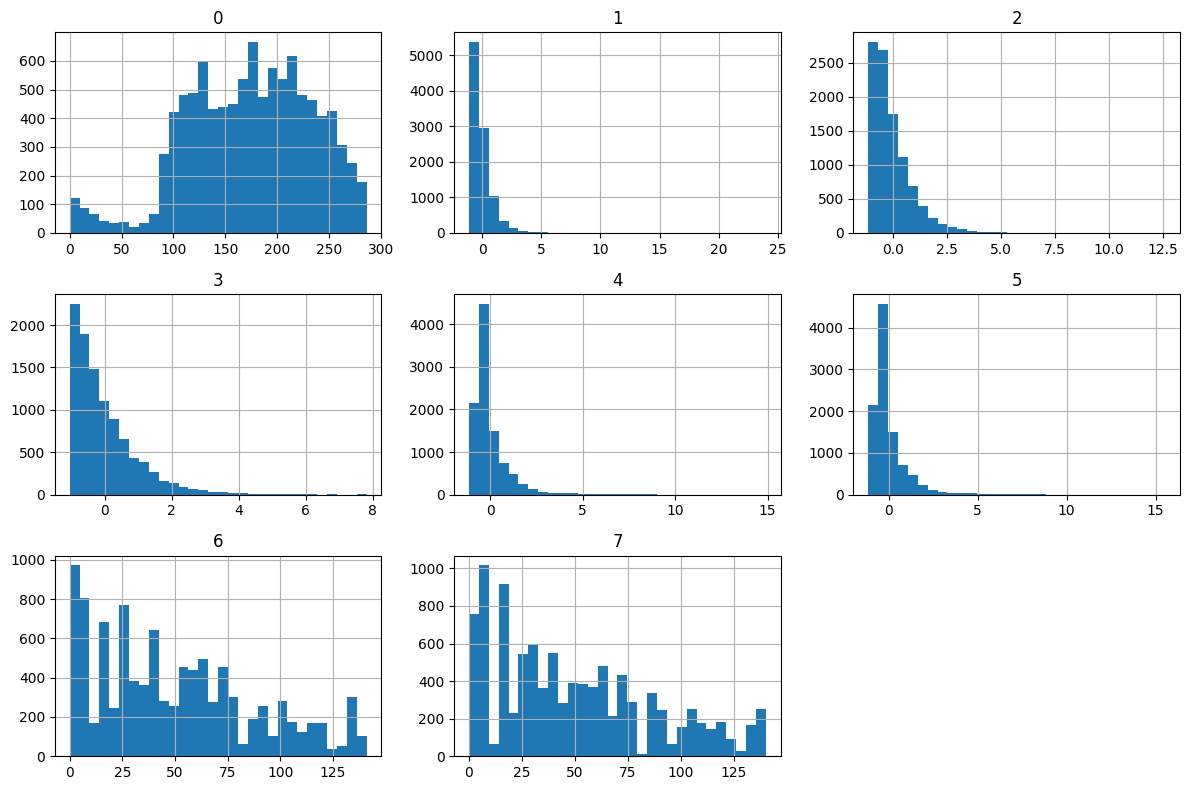

In [ ]:
# inspect the original head file

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load the .npy file
heads = np.load('heads.npy', allow_pickle=True)

# Inspect the content
print(type(heads))
print(heads.shape)
print(heads[3])  # example: print the first element

# If each head is a vector (list/array of numbers)
df = pd.DataFrame(heads)

# Basic statistics
print(df.describe())

# Optional: visualize distributions


df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

# 0, 6, 7 are categorical values

In [ ]:
import pandas as pd
from ast import literal_eval
from tqdm import tqdm

tqdm.pandas()
df = pd.read_csv("dataset\porto.csv")


# convert the POLYLINE from str to list
import multiprocessing as mp
from ast import literal_eval

with mp.Pool(processes=mp.cpu_count()) as pool:
    results = list(tqdm(
        pool.imap(literal_eval, df['POLYLINE']),
        total=len(df),
        desc="Parsing POLYLINE"
    ))

Parsing POLYLINE: 100%|██████████| 1710670/1710670 [03:23<00:00, 8387.48it/s] 


there are 36510 instances has the number of locations points less than 2


In [ ]:
df_pp = pd.DataFrame({'POLYLINE': results})


# drop length of POLYLINE < 2
len_before = len(df)

df_pp.drop(df[df['POLYLINE'].apply(len) < 2].index, inplace=True)
len_after  = len(df_pp)

print(f"there are {len_before - len_after} instances has the number of locations points less than 2")

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def linear_interpo(polyline):
    traj = np.array(polyline)
    l = len(traj)
    if l == 0:
        # Handle empty trajectory
        interp_traj = np.zeros((200, 2))
    elif l == 1:
        # Handle single-point trajectory by repeating
        interp_traj = np.repeat(traj, 200, axis=0)
    else:
        # Original time steps and desired 200 steps
        orig_t = np.linspace(0, 1, l)
        target_t = np.linspace(0, 1, 200)



        # Interpolate x and y separately
        f_x = interp1d(orig_t, traj[:, 0], kind='linear')
        f_y = interp1d(orig_t, traj[:, 1], kind='linear')

        interp_traj = np.stack([f_x(target_t), f_y(target_t)], axis=1)  # shape (200, 2)

    return interp_traj  # shape (200, 2)

def unix_to_5min_interval(timestamps):
    """
    Converts Unix timestamps to 5-minute interval indices (0–287) within a day.

    Parameters:
        timestamps (array-like or pd.Series): Unix timestamps (in seconds)

    Returns:
        pd.Series: 5-minute interval indices ranging from 0 to 287
    """
    # Convert to datetime in Porto timezone (Europe/Lisbon)
    datetime = pd.to_datetime(timestamps, unit='s', utc=True).dt.tz_convert('Europe/Lisbon')

    # Compute minutes since midnight
    minutes = datetime.dt.hour * 60 + datetime.dt.minute

    # Compute 5-minute interval index
    interval = minutes // 5

    return interval


def compute_trip_distance(polyline):
    """
    Computes the Euclidean distance between start and end points of each trajectory.

    Parameters:
        polyline_series (pd.Series): Each entry is a list of (x, y) points.

    Returns:
        np.ndarray: 1D array of distances
    """

    traj = np.array(polyline)

    start = traj[0]
    end = traj[-1]
    dist = np.linalg.norm(end - start)  # ||end - start||

    return dist

def compute_trip_time(polyline):
    """
    Computes trip duration in seconds based on number of points in a trajectory.

    Parameters:
        polyline_series (pd.Series): Each entry is a list of (x, y) points.

    Returns:
        np.ndarray: 1D array of trip times in seconds
    """

    n_points = len(polyline)
    trip_time = max(0, (n_points - 1) * 15)  # at least 0
    
    return trip_time



In [ ]:
# manually calculated features
#  [batch_size, 8]   8: departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed, start_id, end_id

# x departure_time = convert unix time to categorical values  (a day has been categorise into 288 intervals, every 5 minutes as a interval)
# x trip_distance = ||start coordinate - end coordinate||
# x trip_time: (number of points-1) x 15 seconds
# x trip_length = number of points
# x avg_dis = trip_distance / trip_length
# x avg_speed = trip_distance / trip_time
# start_id: id of start grid 
# end_id: id of end grid 


df_pp['trip_distance'] = df_pp['POLYLINE'].progress_apply(compute_trip_distance)

df_pp['departure_time'] = unix_to_5min_interval(df['TIMESTAMP'])

df_pp['trip_time'] = df_pp['POLYLINE'].progress_apply(compute_trip_time)

df_pp['trip_length'] = df_pp['POLYLINE'].progress_apply(len)

df_pp['avg_dis'] = df_pp['trip_distance'] / df_pp['trip_length']

df_pp['avg_speed'] = df_pp['trip_distance'] / df_pp['trip_length']


  0%|          | 1/1710670 [00:00<1:26:00, 331.49it/s]


TypeError: compute_trip_distance() got an unexpected keyword argument 'desc'

In [ ]:
# 分装到traj和head
# traj: [batch_size, 2, traj_length]   2: latitude and longitude

# linear interpolate to length = 200
df['POLYLINE'] = df['POLYLINE'].apply(linear_interpo)



#  [batch_size, 8]   8: departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed, start_id, end_id

# X departure_time = convert unix time to categorical values  (a day has been categorise into 288 intervals, every 5 minutes as a interval)
# x trip_distance = ||start coordinate - end coordinate||
# x trip_time: (number of points-1) x 15 seconds
# x trip_length = number of points
# avg_dis = trip_distance / trip_length
# avg_speed = trip_distance / trip_time
# start_id: id of start grid 
# end_id: id of end grid 



TypeError: len() of unsized object

In [ ]:
from multiprocessing import Pool, cpu_count

# Sample: assuming df['POLYLINE'] already contains lists of [lon, lat]
# Step 1: filter out empty polylines
non_empty_df = df[df['POLYLINE'].apply(lambda x: len(x) > 0)]

# Step 2: define a function to extract min/max from each trajectory
def get_min_max_from_traj(traj):
    coords = np.array(traj)
    min_lon, min_lat = coords.min(axis=0)
    max_lon, max_lat = coords.max(axis=0)
    return min_lat, max_lat, min_lon, max_lon

# Step 3: apply with multiprocessing
with Pool(cpu_count()) as pool:
    results = pool.map(get_min_max_from_traj, non_empty_df['POLYLINE'])


In [ ]:
import multiprocessing
import pandas as pd
from tqdm import tqdm
import numpy as np
from ast import literal_eval

df = pd.read_csv("dataset\porto.csv")

def get_min_max_from_traj(traj):
    traj = literal_eval(traj)
    if len(traj) == 0:
        return

    coords = np.array(traj)
    min_lon, min_lat = coords.min(axis=0)
    max_lon, max_lat = coords.max(axis=0)
    return min_lat, max_lat, min_lon, max_lon

get_min_max_from_traj(df.head(1)['POLYLINE'][0])

(np.float64(41.141376),
 np.float64(41.154516),
 np.float64(-8.632746),
 np.float64(-8.618499))

In [ ]:
import multiprocessing
import pandas as pd
from tqdm import tqdm
from ast import literal_eval
import numpy as np

df = pd.read_csv("dataset\porto.csv")

def get_min_max_from_traj(traj):
    traj = literal_eval(traj)

    if len(traj) == 0:
        return

    coords = np.array(traj)
    min_lon, min_lat = coords.min(axis=0)
    max_lon, max_lat = coords.max(axis=0)
    return min_lat, max_lat, min_lon, max_lon

data_to_process = df.head(100)['POLYLINE']
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# for result in tqdm(pool.imap_unordered(get_min_max_from_traj, data_to_process[0]), total=len(data_to_process)):
#     print(result)
data_to_process.apply(get_min_max_from_traj)

0     (41.141376, 41.154516, -8.632746, -8.618499)
1     (41.159826, 41.170671, -8.670942, -8.639847)
2      (41.140278, 41.154507, -8.650395, -8.59653)
3       (41.142555, 41.15196, -8.610849, -8.57466)
4     (41.171841, 41.180517, -8.689086, -8.645949)
                          ...                     
95      (41.147775, 41.160969, -8.630028, -8.6103)
96     (41.146164, 41.159304, -8.604288, -8.59707)
97    (41.128587, 41.143239, -8.602821, -8.586891)
98    (41.173533, 41.180544, -8.654778, -8.645787)
99    (41.153562, 41.159619, -8.638902, -8.610381)
Name: POLYLINE, Length: 100, dtype: object

In [ ]:
from multiprocessing import Pool, cpu_count
import tqdm  # or thread_map
import time
import numpy as np
# Filter out empty trajectories

num_rows = len(df['POLYLINE'])
n_workers = cpu_count()-1
chunks = np.array_split(df['POLYLINE'], n_workers)

# Function to extract per-trajectory min/max
def get_min_max_from_traj(traj):
    coords = np.array(traj)
    min_lon, min_lat = coords.min(axis=0)
    max_lon, max_lat = coords.max(axis=0)
    return min_lat, max_lat, min_lon, max_lon


# r = process_map(get_min_max_from_traj, df['POLYLINE'], max_workers=n_workers)
with Pool(processes=n_workers) as pool:
    results = pool.map(get_min_max_from_traj, chunks)
    # results = list(tqdm(pool.imap(get_min_max_from_traj, chunks), total=len(chunks)))
    pool.close()
    pool.join()

# # Multiprocessing with tqdm
# results = []
# with Pool(cpu_count()) as pool:
#     for res in tqdm(pool.imap(get_min_max_from_traj, df['POLYLINE']), total=num_rows):
#         results.append(res)

c:\Users\laizh\anaconda3\envs\difftraj\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def get_min_max_from_traj(traj):
    coords = np.array(traj)
    min_lon, min_lat = coords.min(axis=0)
    max_lon, max_lat = coords.max(axis=0)
    
    return min_lat, max_lat, min_lon, max_lon

In [2]:
from utils.utils import divide_grids, distance

latgrids, longrids = divide_grids(boundary,16)


NameError: name 'boundary' is not defined